<a href="https://www.kaggle.com/code/revanthnamineni/gsr-brain-dead?scriptVersionId=123203563" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <center>  EMOTION DETECTION </center>
## <center>Team GSR👍</center>

## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet169 Model](#model)  ##
## [5. Training and Fine Tuning](#train) ##
## [6. Visualizing Results](#vis) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [2]:
train_dir = '/kaggle/input/brain-dead-emotion-detection/brain_dead_emotion_detection/Train'
test_dir = '/kaggle/input/brain-dead-emotion-detection/brain_dead_emotion_detection/Test'

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Angry','Happy','Neutral','Sad']

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [3]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 1450 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Found 369 images belonging to 4 classes.


## Images with different emotions

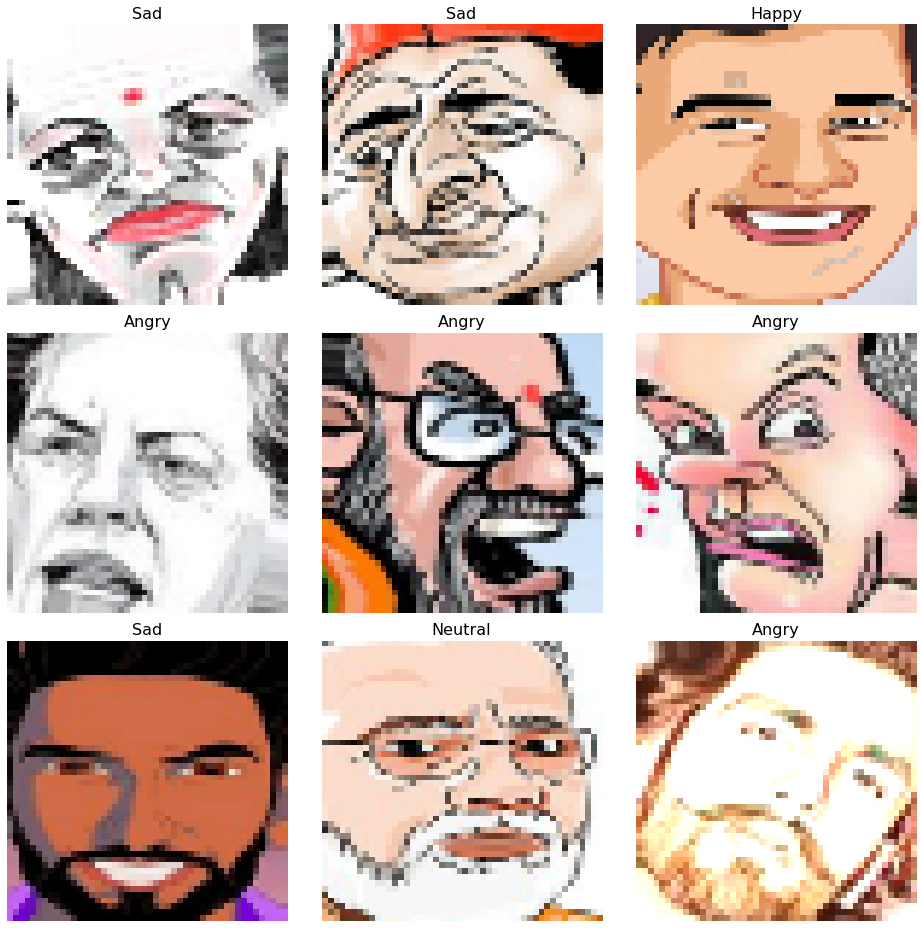

In [4]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [5]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet169 Transfer Learning  </center>

In [6]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(4, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

## Summary of model

In [7]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

<a id="train"></a>
# <center> Training and Fine-Tuning </center> 

## Training model with freezed layers of DenseNer169

In [8]:
LEARNING_RATE = 0.001
from tensorflow.keras.optimizers import Adam
OPTIMIZER = Adam(lr=LEARNING_RATE)


In [9]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_CRITERIA,
    verbose=1,
    restore_best_weights=True
)

model.compile(
    optimizer=OPTIMIZER,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[earlyStoppingCallback]
)

history_df = pd.DataFrame(history.history)


Epoch 1/30
23/23 [==============================] - 33s 712ms/step - loss: 12.1627 - accuracy: 0.2910 - val_loss: 8.2252 - val_accuracy: 0.3583
Epoch 2/30
23/23 [==============================] - 6s 244ms/step - loss: 6.2253 - accuracy: 0.3297 - val_loss: 4.5508 - val_accuracy: 0.3361
Epoch 3/30
23/23 [==============================] - 6s 275ms/step - loss: 3.7266 - accuracy: 0.3414 - val_loss: 3.0434 - val_accuracy: 0.4000
Epoch 4/30
23/23 [==============================] - 6s 268ms/step - loss: 2.6832 - accuracy: 0.3745 - val_loss: 2.3710 - val_accuracy: 0.3528
Epoch 5/30
23/23 [==============================] - 6s 259ms/step - loss: 2.1753 - accuracy: 0.3779 - val_loss: 1.9351 - val_accuracy: 0.4333
Epoch 6/30
23/23 [==============================] - 6s 252ms/step - loss: 1.8991 - accuracy: 0.3772 - val_loss: 1.7582 - val_accuracy: 0.3944
Epoch 7/30
23/23 [==============================] - 6s 259ms/step - loss: 1.7073 - accuracy: 0.3731 - val_loss: 1.5931 - val_accuracy: 0.4333
Epoc

## Fine Tuning

In [10]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
import pandas as pd

# create an empty dataframe to store the training history
history = pd.DataFrame()

# train the model and append the history to the dataframe
for epoch in range(FINE_TUNING_EPOCHS):
    history_ = model.fit(x=train_generator, epochs=1, validation_data=validation_generator)
    epoch_history = pd.DataFrame(history_.history)
    history = history.append(epoch_history, ignore_index=True)


history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

23/23 [==============================] - 7s 291ms/step - loss: 1.2180 - accuracy: 0.4793 - val_loss: 8.6670 - val_accuracy: 0.3306
Epoch 1/20
23/23 [==============================] - 7s 284ms/step - loss: 1.2028 - accuracy: 0.4903 - val_loss: 7.5433 - val_accuracy: 0.3306
Epoch 2/20
23/23 [==============================] - 6s 267ms/step - loss: 1.1921 - accuracy: 0.4917 - val_loss: 6.3112 - val_accuracy: 0.3306
Epoch 3/20
23/23 [==============================] - 8s 327ms/step - loss: 1.1784 - accuracy: 0.5007 - val_loss: 5.3180 - val_accuracy: 0.3361
Epoch 4/20
23/23 [==============================] - 6s 276ms/step - loss: 1.1774 - accuracy: 0.5028 - val_loss: 3.5577 - val_accuracy: 0.3250
Epoch 5/20
23/23 [==============================] - 6s 272ms/step - loss: 1.1661 - accuracy: 0.5055 - val_loss: 3.0471 - val_accuracy: 0.3194
Epoch 6/20
23/23 [==============================] - 7s 281ms/step - loss: 1.1507 - accuracy: 0.5103 - val_loss: 2.5101 - val_accuracy: 0.3333
Epoch 7/20
23/23 

## Training plots

In [11]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [12]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center> 

## Model Evaluation

In [13]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

6/6 [==============================] - 3s 642ms/step - loss: 1.3745 - accuracy: 0.3496


## Confusion Matrix

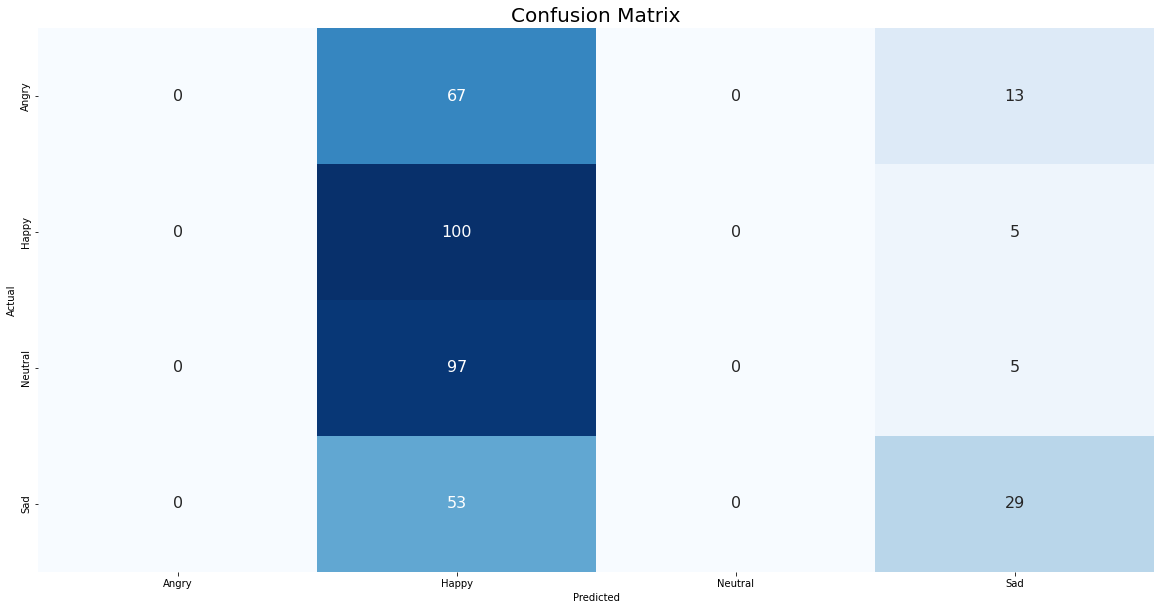

In [14]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [15]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.32      0.95      0.47       105
           2       0.00      0.00      0.00       102
           3       0.56      0.35      0.43        82

    accuracy                           0.35       369
   macro avg       0.22      0.33      0.23       369
weighted avg       0.21      0.35      0.23       369



## Multiclass AUC Curve

ROC AUC score: 0.6569514520800132


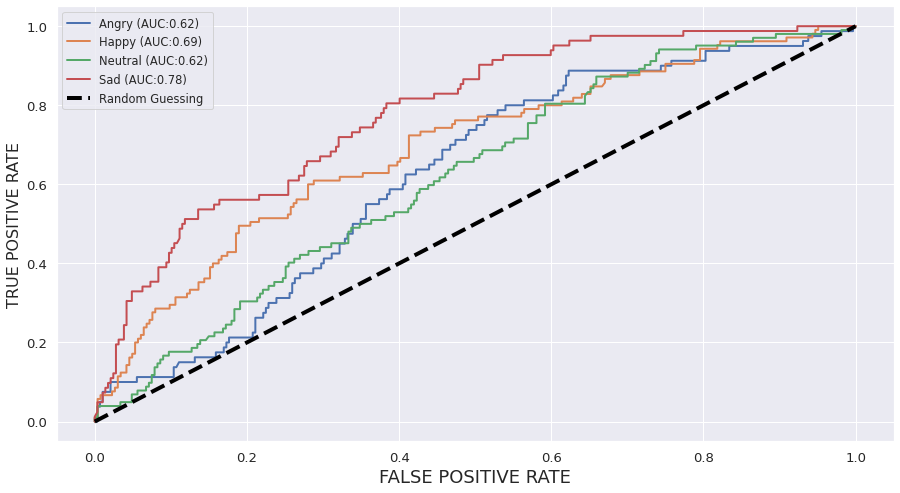

In [16]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [17]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.6786667687698318
